In [2]:
#%pip install pandas
import pandas as pd
pd.set_option('display.max_rows', 1000)

# Enter the data for your analysis - control strain results and results for the transformants - if you're analysing more then one construct, copy the empty datafremes for 
# cassettes = [control, CCW12....]

cassette = 

data = pd.DataFrame({'cassette': [], 
                     'timepoint': [], 
                     'clone': [],
                     'growth': []})


In [3]:
import kmeans1d
from statistics import mode

def cluster_and_mode(data, feature):
    list_data_feature = list(data[feature])
    clusters, _ = kmeans1d.cluster(list_data_feature, k=3)
    data[f'{feature}_clusters'] = clusters

    mode_cluster = mode(clusters)
    mode_clusters = data[data[f'{feature}_clusters'] == mode_cluster]
    return mode_clusters

features = ['growth']
timepoints = data['timepoint'].unique()


# Accumulate common clones for each feature and timepoint
common_clones_accumulated = {}
for feature in features:
    for timepoint in timepoints:
        subset = data[(data['cassette'] == cassette) & (data['timepoint'] == timepoint)][['clone', feature]]
        clusters_mode = cluster_and_mode(subset, feature)
        current_clones = set(clusters_mode['clone'])
        print(f"Feature: {feature}, Timepoint: {timepoint}, Common Clones: {current_clones}")
        if (feature, timepoint) not in common_clones_accumulated:
            common_clones_accumulated[(feature, timepoint)] = current_clones
        else:
            common_clones_accumulated[(feature, timepoint)].intersection_update(current_clones)

# Perform intersection for all feature and timepoint combinations
common_clones = set.intersection(*common_clones_accumulated.values())



# Define the order of subsets to exclude
subset_order = ['growth', 'r-Prot', 'normalized_r-Prot']

deleted_subsets = []

# Check if at least 3 common clones are found
while len(common_clones) < 1 and common_clones_accumulated:
    # Sort subsets by timepoint in ascending order
    sorted_subsets = sorted(common_clones_accumulated.keys(), key=lambda x: (x[1], subset_order.index(x[0])))

    # Iterate over sorted subsets
    for subset in sorted_subsets:
        # Exclude the current subset
        deleted_subsets.append(subset)
        del common_clones_accumulated[subset]

        # Recalculate common clones
        common_clones = set.intersection(*common_clones_accumulated.values())

        # Check if at least 3 common clones are found
        if len(common_clones) >= 3:
            break

# Print the final result

print("Deleted Subsets:", deleted_subsets)

Feature: growth, Timepoint: 0, Common Clones: {'8', '22', '18', '5', '11', '17', '9', '4', '12', '1', '20', '24', '10', '13', '6', '3', '14', '7', '19', '2', '23', '16', '15', '21'}
Feature: growth, Timepoint: 24, Common Clones: {'4', '2', '6', '3', '12', '23', '8', '16', '15', '20', '18', '5', '14', '9', '7'}
Feature: growth, Timepoint: 35, Common Clones: {'4', '2', '6', '3', '12', '23', '8', '16', '15', '20', '18', '5', '14', '9', '7'}
Feature: growth, Timepoint: 48, Common Clones: {'8', '18', '5', '17', '9', '4', '12', '1', '20', '24', '10', '6', '3', '14', '7', '2', '23', '16', '15'}
Deleted Subsets: []


In [4]:
import numpy as np
pd.set_option('display.max_columns', 1000)


data_stat = data.groupby(['cassette', 'timepoint', 'clone']).agg({'growth': ['mean', 'std']}).reset_index()
data_stat.fillna(0, inplace=True)

print(data_stat)

            cassette timepoint    clone  growth          
                                           mean       std
0           emptyURA         0        1   0.000  0.000000
1           emptyURA         0       10   0.000  0.000000
2           emptyURA         0       11   0.000  0.000000
3           emptyURA         0       12   0.000  0.000000
4           emptyURA         0       13   0.000  0.000000
5           emptyURA         0       14   0.000  0.000000
6           emptyURA         0       15   0.000  0.000000
7           emptyURA         0       16   0.000  0.000000
8           emptyURA         0       17   0.000  0.000000
9           emptyURA         0       18   0.000  0.000000
10          emptyURA         0       19   0.000  0.000000
11          emptyURA         0        2   0.000  0.000000
12          emptyURA         0       20   0.000  0.000000
13          emptyURA         0       21   0.000  0.000000
14          emptyURA         0       22   0.000  0.000000
15          em

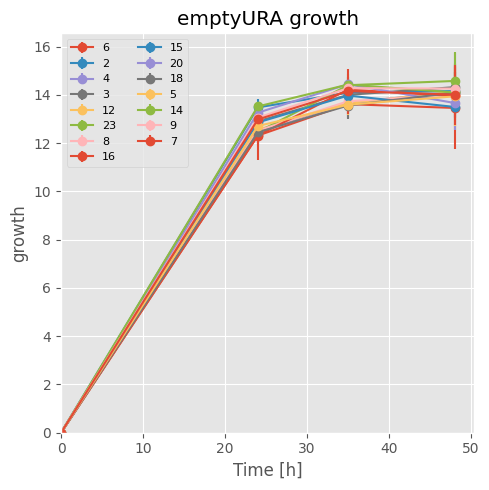

In [12]:
#%pip install matplotlib

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

plt.style.use('ggplot')

# 3x subplot - growth, total r-Prot, normalized r-Prot
plt.figure(figsize=(5, 5))

chosen_clones = common_clones

for clone in chosen_clones:
    clone_data = data_stat[(data_stat['clone'] == clone) & (data_stat['cassette'] == cassette)]
    mean_values = clone_data['growth', 'mean']
    std_values = clone_data['growth', 'std']

    plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', 
                         linestyle='-', linewidth=1.5)

plt.title(f'{cassette} growth')
plt.xlabel('Time [h]')
plt.ylabel(f'growth')
plt.xlim(0,)
plt.ylim(0,)
plt.legend(ncol=2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(f'chosen_{cassette}.png')
plt.show()

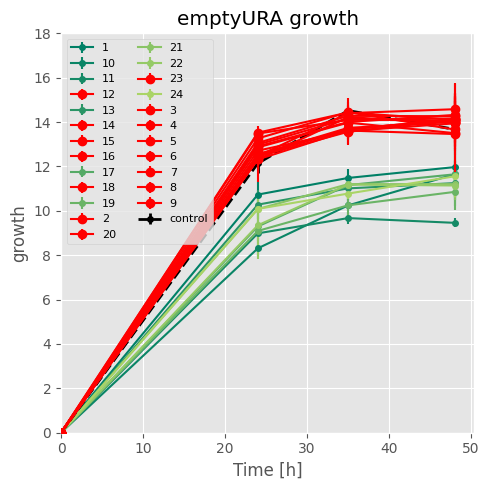

In [15]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

plt.style.use('ggplot')

# 3x subplot - growth, total r-Prot, normalized r-Prot
plt.figure(figsize=(5, 5))

colormap = plt.colormaps['summer']
normalize = plt.Normalize(vmin=0, vmax=len(data_stat['clone'].unique()) - 1)
scalar_map = ScalarMappable(cmap=colormap, norm=normalize)

chosen_clones = common_clones

for j, clone in enumerate(data_stat['clone'].unique()):
    clone_data = data_stat[(data_stat['clone'] == clone) & (data_stat['cassette'].isin([cassette, 'empty_ura_control']))]
    mean_values = clone_data['growth', 'mean']
    std_values = clone_data['growth', 'std']

    if clone == 'control':
        plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize = 4, 
                         linestyle='--', color='black', linewidth=2, zorder = 2)
    elif clone in chosen_clones:
        plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', 
                         linestyle='-', color='red', linewidth=1.5, zorder = 3)
    else:
        color = colormap(normalize(j))
        plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize = 4, 
                         linestyle='-', color=color, zorder = 1)

    plt.title(f'{cassette} growth')
    plt.xlabel('Time [h]')
    plt.ylabel(f'growth')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.legend(ncol=2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(f'{cassette}.png')
plt.show()

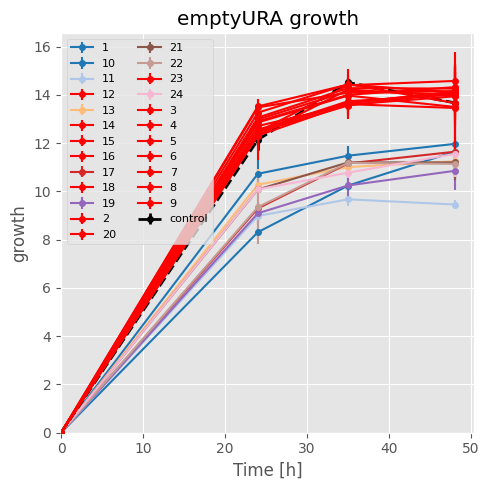

In [17]:
plt.style.use('ggplot')

# 3x subplot - growth, total r-Prot, normalized r-Prot
plt.figure(figsize=(5, 5))


chosen_clones = common_clones

for j, clone in enumerate(data_stat['clone'].unique()):
    clone_data = data_stat[(data_stat['clone'] == clone) & (data_stat['cassette'].isin([cassette, 'empty_ura_control']))]
    mean_values = clone_data['growth', 'mean']
    std_values = clone_data['growth', 'std']

    if clone == 'control':
        plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize = 4, 
                         linestyle='--', color='black', linewidth=2, zorder = 2)
    elif clone in chosen_clones:
        plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize = 4,
                         linestyle='-', color='red', linewidth=1.5, zorder = 3)
    else:
        color = plt.cm.tab20(normalize(j))
        plt.errorbar(clone_data['timepoint'], mean_values, yerr=std_values, label=clone, marker='o', markersize=4,
                 linestyle='-', color=color, zorder=1)

plt.title(f'{cassette} growth')
plt.xlabel('Time [h]')
plt.ylabel(f'growth')
plt.xlim(0,)
plt.ylim(0,)
plt.legend(ncol=2, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(f'{cassette}2.png')
plt.show()
